## Import Libraries

In [1]:
import os
    
# Main libraries that we will use in this kernel
import datetime
import numpy as np
import pandas as pd

# # garbage collector: free some memory is needed
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


import time

from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.path.abspath(os.getcwd())
PATH = "/content/drive/MyDrive/Master Data Science/Capstone NDS/Dataset/"
os.chdir(PATH)

In [5]:
!pip install pickle5

In [6]:
import pickle5 as pickle
data = pickle.load( open( "df_pickle", "rb" ))

## Functions

In [7]:
#10 € por cada cuenta vendida, 40€ por productos de ahorro e inversión (planes, fondos, etc) y 60 por finnanciación (prestamos y tarjetas)

v_10 = ['em_acount_diff', 'emc_account_diff', 'payroll_account_diff','em_account_p_diff']
v_40 = ['funds_diff', 'pension_plan_diff', 'short_term_deposit_diff', 'long_term_deposit_diff', 'securities_diff']
v_60 = ['loans_diff', 'mortgage_diff', 'debit_card_diff', 'credit_card_diff']

def calc_revenue(df):
  for column in df.columns:
    if 'diff' in column:
      if column in v_10:
        df['revenue_'+column] = 10*df[df[column]==1][column]
        df = df.drop(columns=column,axis=1)
      elif column in v_60:
        df['revenue_'+column] = 60*df[df[column]==1][column]
        df = df.drop(columns=column, axis=1)
      else:
        df['revenue_'+column] = 40*df[df[column]==1][column]
        df = df.drop(columns=column, axis=1)
  return df

In [8]:
def alta_baja(df,new_df):
    for column in df.columns:
        if 'diff' in column:
            new_df[column[:-5]] = df[column[:-5]]
            new_df['baja_'+column] = df[df[column]==-1][column]
            new_df['alta_'+column] = df[df[column]==1][column]
            new_df['total_'+column] = df[column]
    return new_df

In [9]:
def revenue_productos(df,new_df):
    for column in df.columns:
        if 'diff' in column:
            new_df[column] = df[column]
    return new_df

In [10]:
class Plots(object):
    
    def __init__(self, df, products=[]):
        
        self.df = df
        self.products = products

    def alta_baja_plot(self): #Función para plotear altas y bajas por producto
        # resample the data on a monthly basis
        sns.set(style="darkgrid")
        
        #Dataframe para plotear el total de bajas y altas para el grupo entero de productos introducido
        x_sum_altas = self.df.groupby(["pk_partition"])[['alta_'+product+'_diff' for product in self.products]].sum()
        x_sum_bajas = self.df.groupby(["pk_partition"])[['baja_'+product+'_diff' for product in self.products]].sum()
        
        x_sum_altas = x_sum_altas.sum(axis=1)
        x_sum_bajas = x_sum_bajas.sum(axis=1)
        
        x_sum_altas.index = x_sum_altas.index.strftime('%B %Y')
        x_sum_bajas.index = x_sum_bajas.index.strftime('%B %Y')
        
        #Plot de altas y bajas para cada producto
        for product in self.products:
            x = self.df[["pk_partition",product,'baja_'+product+'_diff','alta_'+product+'_diff',
                              'total_'+product+'_diff']].set_index("pk_partition").resample("M").sum()
            fig, ax =plt.subplots(1,2,figsize = (18, 7))
            x.index = x.index.strftime('%B %Y')

            bar1 = sns.barplot(x=x.index,y=x['baja_'+ product +'_diff'],color='darkblue',ax=ax[0])
            bar2 = sns.barplot(x=x.index, y=x['alta_'+ product +'_diff'], estimator=sum, ci=None,  color='lightblue',ax=ax[0])
            line1 = sns.lineplot(data = x['total_'+ product+'_diff'], marker='o', sort = False, color = 'lightcoral',ax=ax[0])
            line2 = sns.lineplot(data = x[product],marker='o',sort = False, color = 'coral',ax=ax[1])
            
            top_bar = mpatches.Patch(color='darkblue', label='Withdraw')
            bottom_bar = mpatches.Patch(color='lightblue', label='Subscription')
            balance_line = mpatches.Patch(color = 'lightcoral',label = 'Balance')
            total_line = mpatches.Patch(color = 'coral',label = 'Total')

            ax[0].legend(handles=[top_bar, bottom_bar,balance_line])
            ax[0].tick_params(labelrotation=45)
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(product)
            ax[0].title.set_text("Monthly subscriptions")

            ax[1].legend(handles=[total_line])
            ax[1].tick_params(labelrotation=45)
            ax[1].set_xlabel('Time')
            ax[1].set_ylabel(product)
            ax[1].title.set_text("Total active subscriptors")

            plt.show()
            
        #Plot del total de bajas y altas del grupo entero de productos.    
        plt.figure(figsize = (18, 7)) 
        bar_sum_altas = sns.barplot(x=x_sum_altas.index,y=x_sum_altas.values,color='lightblue')
        bar_sum_bajas = sns.barplot(x=x_sum_bajas.index,y=x_sum_bajas.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'lightblue',label = 'Subscription')
        sum_bar_bajas = mpatches.Patch(color = 'darkblue',label = 'Withdraw')
        
        plt.title("Monthly registration for the entire group")
        plt.legend(handles = [sum_bar,sum_bar_bajas])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()
        
    def alta_baja_total(self): #función para plotear altas y bajas totales de todos los productos de la empresa

        x_total_alta = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'alta' in column]].sum()
        x_total_baja = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'baja' in column]].sum() 

        x_total_alta = x_total_alta.sum(axis=1)
        x_total_baja = x_total_baja.sum(axis=1)
        
        x_total_alta.index = x_total_alta.index.strftime('%B %Y')
        x_total_baja.index = x_total_baja.index.strftime('%B %Y') 
        
        plt.figure(figsize = (18, 7)) 
        
        altas = sns.barplot(x=x_total_alta.index,y=x_total_alta.values,color='lightblue')
        bajas = sns.barplot(x=x_total_baja.index,y=x_total_baja.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'lightblue',label = 'Subscription')
        sum_bar_bajas = mpatches.Patch(color = 'darkblue',label = 'Withdraw')
        
        plt.title("Monthly registration for all portfolio")
        plt.legend(handles = [sum_bar,sum_bar_bajas])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()
        
    def revenue_plot(self):

        for index in range(len(self.products)):
            self.products[index] = 'revenue_'+self.products[index]+'_diff'
        # resample the data on a monthly basis

        x = self.df[["pk_partition"]+self.products].set_index("pk_partition").resample("M").sum()
        x.index = x.index.strftime('%B %Y')

        x = x.reset_index()
        x_melted = x.melt(id_vars='pk_partition')

        plt.figure(figsize = (18, 7))
        sns.barplot(x='pk_partition', y='value', hue='variable', data=x_melted)
        plt.title("Monthly sales")
        plt.xticks(rotation=45)
        plt.legend();

        
    def total_revenue_plot(self):

        
        x_total_revenue = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'revenue' in column]].sum()

        x_total_revenue = x_total_revenue.sum(axis=1)
        
        x_total_revenue.index = x_total_revenue.index.strftime('%B %Y')

        plt.figure(figsize = (18, 7)) 
        sns.barplot(x=x_total_revenue.index,y=x_total_revenue.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'darkblue',label = 'Total revenue')

        
        plt.title("Monthly revenue for all portfolio")
        plt.legend(handles = [sum_bar])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()

## Revenue analysis

In [11]:
rev_data = pd.DataFrame()
rev_data[['pk_cid', 'pk_partition']] = data[['pk_cid', 'pk_partition']]
rev_data = revenue_productos(data,rev_data)
rev_data =calc_revenue(rev_data)

### Total revenue

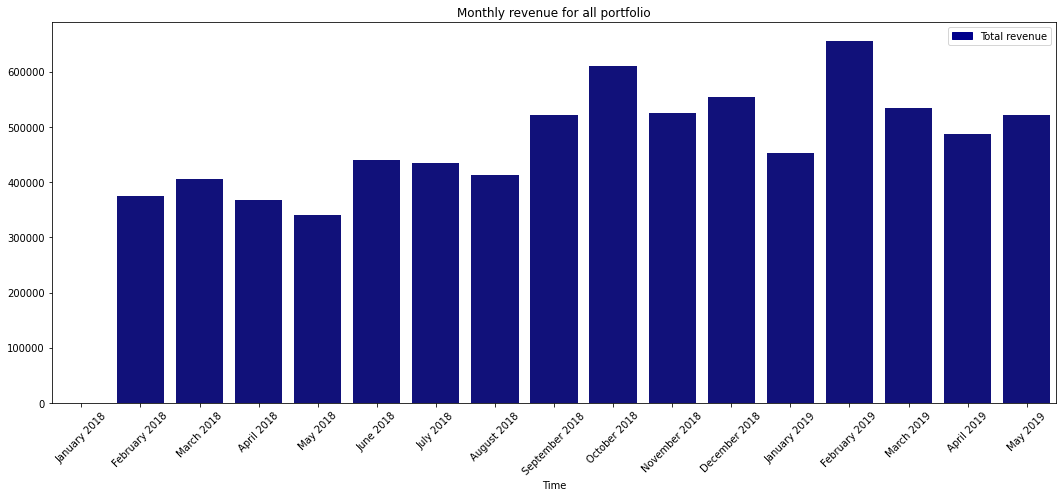

In [12]:
revenue_total = Plots(df=rev_data)

revenue_total.total_revenue_plot()

### Revenue per product group

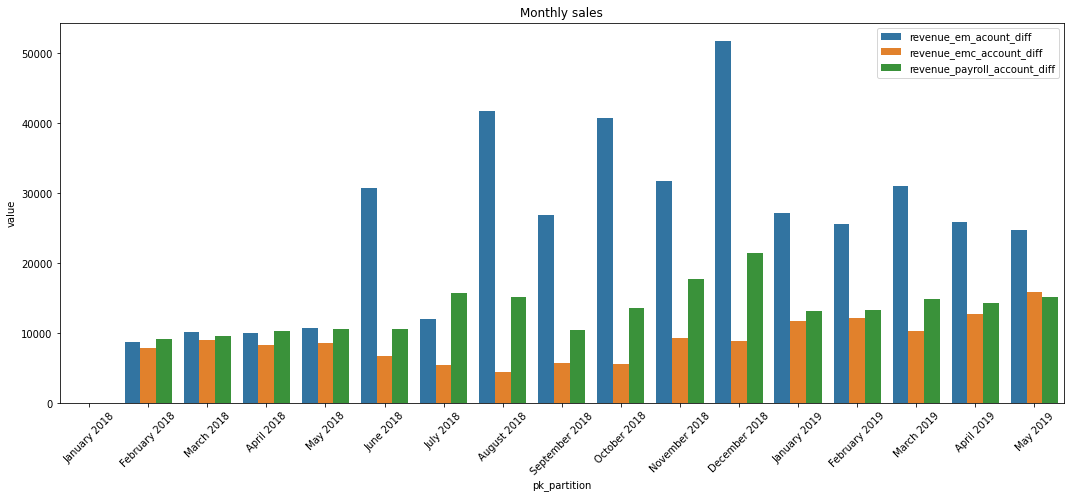

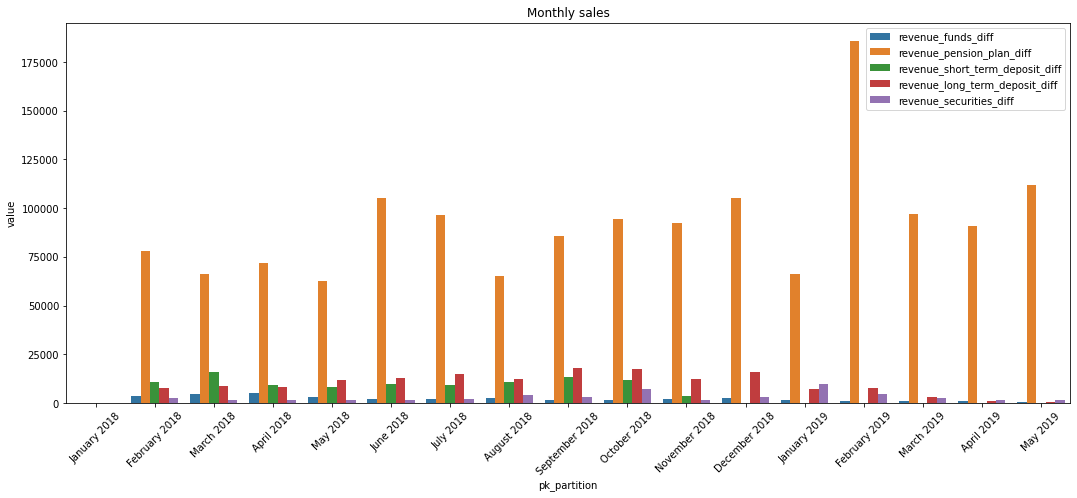

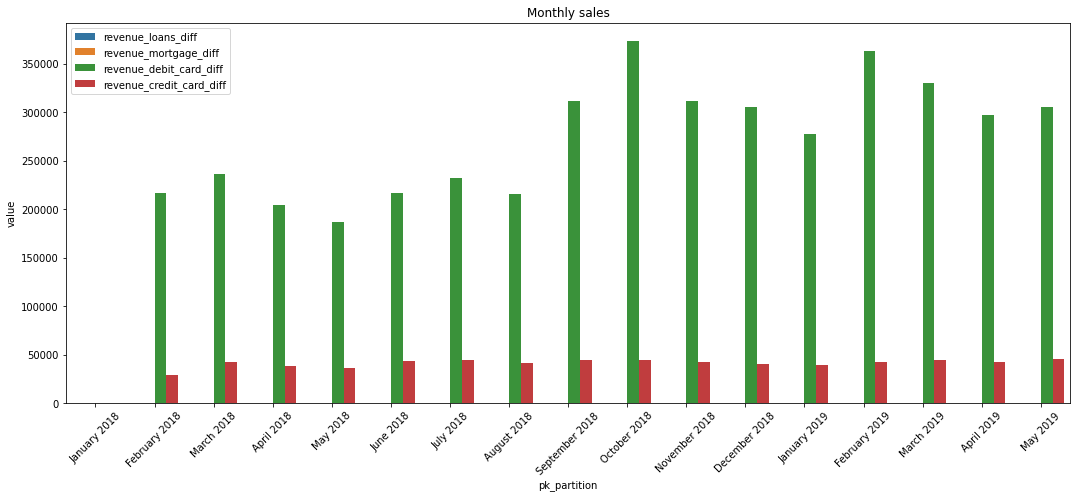

In [13]:
v_10 = ['em_acount', 'emc_account', 'payroll_account']
v_40 = ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities']
v_60 = ['loans', 'mortgage', 'debit_card', 'credit_card']

revenue_class_10 = Plots(df=rev_data,products=v_10)
revenue_class_40 = Plots(df=rev_data,products=v_40)
revenue_class_60 = Plots(df=rev_data,products=v_60)

revenue_class_10.revenue_plot()
revenue_class_40.revenue_plot()
revenue_class_60.revenue_plot()